In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.optimizers import Adam

In [2]:
def generate_emg_signal(duration, fs, freqs, amplitudes, noise_std_dev):
    t = np.arange(0, duration, 1/fs)
    emg_signal = np.zeros_like(t)
    for freq, amp in zip(freqs, amplitudes):
        emg_signal += amp * np.sin(2 * np.pi * freq * t)
    noise = np.random.normal(0, noise_std_dev, len(t))
    emg_signal += noise
    return emg_signal


In [3]:
def preprocess_emg_signal(emg_signal, fs, lowcut, highcut):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(2, [low, high], btype="band")
    return signal.lfilter(b, a, emg_signal)

In [4]:
duration = 10
fs = 2000
freqs = [30, 40, 60, 90, 120]
amplitudes = [0.5, 0.8, 0.3, 0.6, 0.9]
noise_std_dev = 0.05

raw_emg_signal = generate_emg_signal(duration, fs, freqs, amplitudes, noise_std_dev)
filtered_emg_signal = preprocess_emg_signal(raw_emg_signal, fs, 20, 500)


In [5]:
def create_dataset(num_samples, window_size, step_size):
    X, y = [], []
    for _ in range(num_samples):
        raw_emg_signal = generate_emg_signal(duration, fs, freqs, amplitudes, noise_std_dev)
        filtered_emg_signal = preprocess_emg_signal(raw_emg_signal, fs, 20, 500)
        for i in range(0, len(filtered_emg_signal) - window_size, step_size):
            X.append(filtered_emg_signal[i:i+window_size])
            y.append(np.mean(np.abs(filtered_emg_signal[i:i+window_size])))
    return np.array(X), np.array(y)

In [6]:
num_samples = 500
window_size = 1000
step_size = 500

X, y = create_dataset(num_samples, window_size, step_size)

# Reshape the input for the model
X = X.reshape((X.shape[0], X.shape[1], 1))

In [7]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

input_shape = (window_size, 1)
model = create_model(input_shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 32)           1568      
                                                                 
 flatten (Flatten)           (None, 31872)             0         
                                                                 
 dense (Dense)               (None, 64)                2039872   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,041,569
Trainable params: 2,041,569
Non-trainable params: 0
_________________________________________________________________


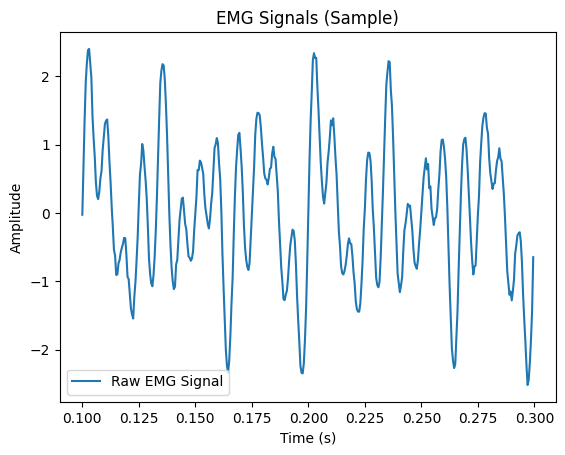

In [23]:
start_time = 0.1  
end_time = 0.3   
start_index = int(start_time * fs)
end_index = int(end_time * fs)

t_sample = t[start_index:end_index]
raw_emg_sample = raw_emg_signal[start_index:end_index]
emg_noisy_sample = emg_noisy[start_index:end_index]
filtered_emg_sample = filtered_emg_signal[start_index:end_index]
plt.figure()
plt.plot(t_sample, raw_emg_sample, label='Raw EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EMG Signals (Sample)')
plt.legend()
plt.show()


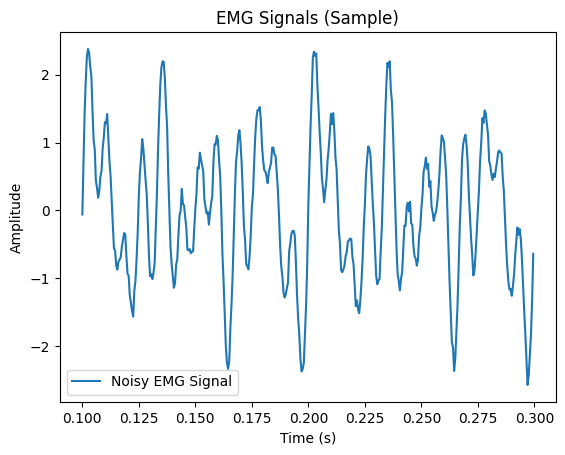

In [24]:
plt.figure()
plt.plot(t_sample, emg_noisy_sample, label='Noisy EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EMG Signals (Sample)')
plt.legend()
plt.show()

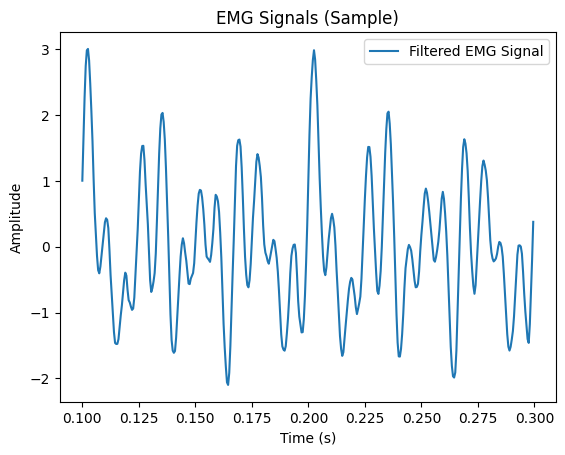

In [25]:
plt.figure()
plt.plot(t_sample, filtered_emg_sample, label='Filtered EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EMG Signals (Sample)')
plt.legend()
plt.show()

In [9]:
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')


split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
475/475 [==============================] - 29s 58ms/step - loss: 4.8212e-04 - val_loss: 1.1737e-06
Epoch 2/20
475/475 [==============================] - 29s 62ms/step - loss: 1.5824e-06 - val_loss: 1.4029e-06
Epoch 3/20
475/475 [==============================] - 29s 62ms/step - loss: 3.0278e-06 - val_loss: 8.0771e-07
Epoch 4/20
475/475 [==============================] - 29s 61ms/step - loss: 1.4524e-05 - val_loss: 1.0052e-05
Epoch 5/20
475/475 [==============================] - 29s 61ms/step - loss: 1.9401e-05 - val_loss: 6.9630e-05
Epoch 6/20
475/475 [==============================] - 30s 62ms/step - loss: 0.0018 - val_loss: 1.4549e-06
Epoch 7/20
475/475 [==============================] - 29s 60ms/step - loss: 1.5954e-06 - val_loss: 1.7328e-06
Epoch 8/20
475/475 [==============================] - 28s 60ms/step - loss: 1.5598e-06 - val_loss: 2.4673e-06
Epoch 9/20
475/475 [==============================] - 28s 60ms/step - loss: 1.6544e-06 - val_loss: 1.5285e-06
Epoch 10/20
47

119/119 [==============================] - 2s 14ms/step - loss: 6.7892e-06
Test loss: 6.789211511204485e-06
119/119 [==============================] - 3s 21ms/step


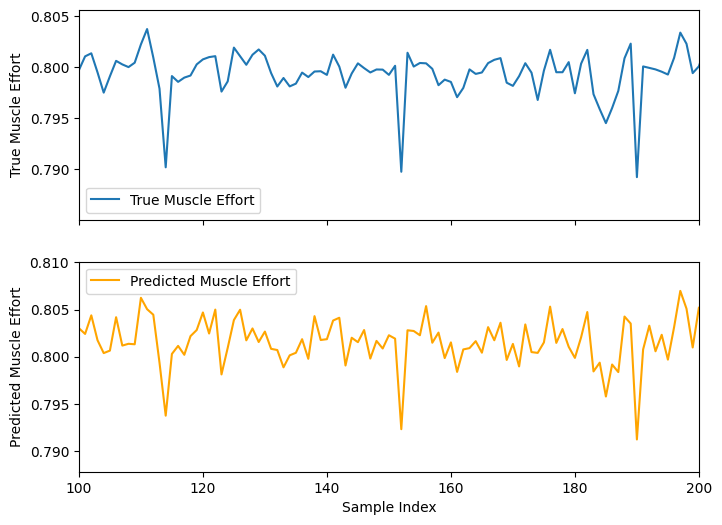

In [26]:

loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# the true muscle effort values and the predicted values
y_pred = model.predict(X_test).flatten()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# True Muscle Effort plot
ax1.plot(y_test, label='True Muscle Effort')
ax1.set_ylabel('True Muscle Effort')
ax1.legend()
ax1.set_xlim(100, 200)  

# Predicted Muscle Effort plot
ax2.plot(y_pred, label='Predicted Muscle Effort', color='orange')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Predicted Muscle Effort')
ax2.legend()
ax2.set_xlim(100, 200)  

plt.show()


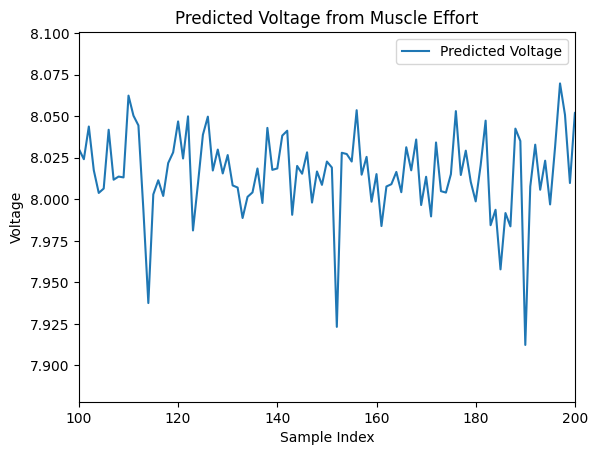

In [29]:
# scaling factor

effort_to_voltage_scale = 10  

# Convert the predicted muscle effort to voltage
predicted_voltage = y_pred * effort_to_voltage_scale

# the predicted voltage
plt.figure()
plt.plot(predicted_voltage, label='Predicted Voltage')
plt.xlabel('Sample Index')
plt.ylabel('Voltage')
plt.title('Predicted Voltage from Muscle Effort')
plt.xlim(100, 200)
plt.legend()
plt.show()